In [5]:
import random

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from arch import arch_model

from garch import GARCH

In [59]:
random.seed(420)
np.random.seed(420)

#### Define a function to generate synthetic data.

In [20]:
def generate_ar_data(ar_coef, T):
    res = [0]
    for t in range(1,T):
        res.append(ar_coef * res[-1] + random.gauss(0, 1))

    return res

In [ ]:
def generate_data(omega: float, alpha: float, beta: float, gamma: float, T: int = 1000, exo_var_count=1):
    e = np.zeros(T)
    sigma2 = np.zeros(T)
    x =np.random.randn(T, exo_var_count)  # generate_ar_data(0.8, T)#

    sigma2[0] = 1  

    for t in range(1, T):  
        sigma2[t] = omega + alpha * e[t-1]**2 + beta * sigma2[t-1] + gamma * x[t-1]**2 
        e[t] = np.random.normal(0, np.sqrt(sigma2[t]))

    return e, sigma2, x

### 1. Generate synthetic data for basic GARCH(1,1)

In [49]:
omega, alpha, beta, gamma = 0.2, 0.3, 0.5, 0
e, sigma2, _ = generate_data(omega, alpha, beta, gamma)

### 2. Generate synthetic data for GARCH(1,1) with one exo variable in the volatility model

### Our GARCH model

* Assumption: exo variable is normally distributed with $ X_t \sim N(0, 1) $

Mean Model
$$ r_t = e_t $$ 
$$e_t \sim N(0, \sigma_t^2)$$

Volatility Model 
$$ \sigma_t^2 = \omega +  \alpha e_{t-1}^2 + \beta \sigma_{t-i}^2 + 
    \gamma x_t^2$$

$$x_t \sim N(0, 1)$$

### Log likelihood
 $$ l(\omega, \alpha, \beta, \gamma) =  \sum_{t=1}^T {\frac{1}{2} ({-\log{2\pi} -\log{\sigma_t^2} - \frac{e_t^2}{\sigma_t^2}})} $$

In [50]:
# Define volatility component coefficients
omega, alpha, beta, gamma = 0.1, 0.1, 0.4, 0.3
e, sigma2, x = generate_data(omega, alpha, beta, gamma)

In [57]:
from statsmodels.stats.diagnostic import acorr_ljungbox
result = acorr_ljungbox(x, lags=[x for x in range(6)], return_df=True)
result

,lb_stat,lb_pvalue
0,1409.354677,NaN
1,610.728817,7.766583e-135
2,976.850553,7.578751e-213
3,1188.474481,2.321910e-257
4,1325.093559,1.206316e-285
5,1409.354677,1.293581e-302


In [51]:
# Fit using ARCH library, without exogeneous
model = arch_model(e, vol='GARCH', mean='zero', p=1, q=1)
garch_fit = model.fit(disp='off', cov_type='classic')

garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1661.20
Distribution:                  Normal   AIC:                           3328.40
Method:            Maximum Likelihood   BIC:                           3343.12
                                        No. Observations:                 1000
Date:                Sat, Mar 01 2025   Df Residuals:                     1000
Time:                        01:39:59   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3924  8.880e-02      4.419  9.893e-06 [  0.218,  0.566]
alpha[1]       0.2572  4.713e-02      5.457  4.837e-08 [  0.165,  0.350]
beta[1]        0.5416  7.044e-02      7.688  1.490e-14 [  0.403,  0.680]
========================================================================

Covariance estimator: classic
"""

In [52]:
# Fit without exogenous
garch_without_exo = GARCH(p=1, q=1, z=0)
garch_without_exo.train(e)

garch_without_exo.summary()

1.48535458202156


,coef,std err,t,P>|t|
omega,0.401192,0.093119,4.308369,9.037113e-06
alpha,0.256162,0.047862,5.352146,5.392958e-08
beta,0.536569,0.073889,7.261774,3.843623e-13


In [53]:
garch_with_exo = GARCH(p=1, q=1, z=1)
garch_with_exo.train(e, x=np.array(x))

garch_with_exo.summary()

1.3339855001194463


,coef,std err,t,P>|t|
omega,0.101551,0.033376,3.042593,1.203489e-03
alpha,0.069141,0.029630,2.333496,9.910180e-03
beta,0.599443,0.051352,11.673106,6.699239e-30
gamma[0],0.180984,0.026642,6.793179,9.420824e-12


In [44]:
from scipy.stats import chi2

def likelihood_ratio_test(ll_null: float, ll_alternative: float, df: int):

    if df <= 0:
        raise ValueError("Degrees of freedom must be positive.")
    
    # Compute test statistic
    lr_stat = 2 * (ll_alternative - ll_null)
    
    # Compute p-value
    p_value = 1 - chi2.cdf(lr_stat, df)
    
    return p_value

In [45]:
likelihood_ratio_test(garch_without_exo.loglikelihood, garch_with_exo.loglikelihood, 1)

0.0

In [46]:
def mse(arr1, arr2):
    if len(arr1) != len(arr2):
        return False
    return np.sum(np.square(np.array(arr1) - np.array(arr2)))

In [47]:
print(mse(sigma2, garch_without_exo.sigma2))
print(mse(sigma2, garch_with_exo.sigma2))


1847.567961942183
519.2068882787012


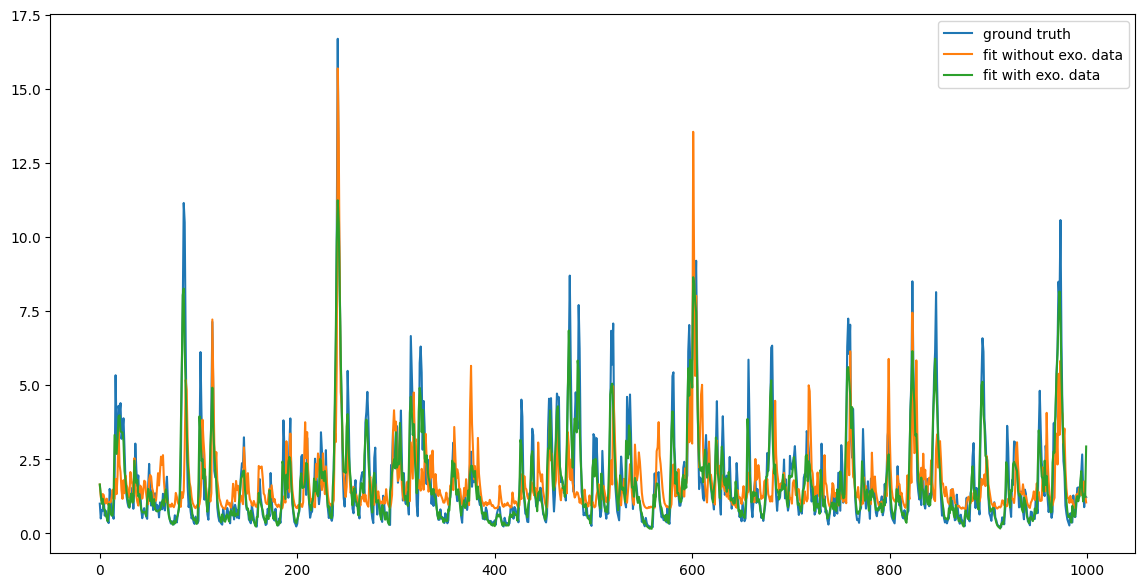

In [48]:

f, axs = plt.subplots(figsize=(14,7))

plt.plot(sigma2, label='ground truth')
plt.plot(garch_without_exo.sigma2, label='fit without exo. data')
plt.plot(garch_with_exo.sigma2, label='fit with exo. data')

plt.legend()

### More rigorous approach: Using a grid of model parameters (see below) to define varying data. For each generated data we fit two models, one without using the exogenous data and another with the exogenous data. We then compare   

In [1]:
import itertools

In [2]:
omegas = [0.1]
alphas = [0.1, 0.4]
betas = [0.1, 0.4]
gammas = [0, 0.1, 0.4]

results = []

for params in itertools.product(omegas, alphas, betas, gammas):

    e, sigma2, x = generate_data(*params)

    param_data = [*params]

    garch_without_exo = GARCH(p=1, q=1, z=0)
    garch_without_exo.train(e)
    model_params = garch_without_exo.omega, garch_without_exo.alpha[0], garch_without_exo.beta[0]
    param_data.extend(model_params)

    garch_with_exo = GARCH(p=1, q=1, z=1)
    garch_with_exo.train(e, x=x)
    model_params = garch_with_exo.omega, garch_with_exo.alpha[0], garch_with_exo.beta[0], garch_with_exo.gammas[0][0]
    param_data.extend(model_params)

    without_exo_MSE = mse(sigma2, garch_without_exo.sigma2)
    with_exo_MSE = mse(sigma2, garch_with_exo.sigma2)
    param_data.extend([without_exo_MSE, with_exo_MSE])

    results.append(param_data)

columns = ['omega', 'alpha', 'beta', 'gamma',
            'omega_wo_exo', 'alpha_wo_exo', 'beta_wo_exo',
            'omega_with_exo', 'alpha_with_exo', 'beta_with_exo', 
            'gamma_with_exo', 'without_exo_MSE', 'with_exo_MSE']
result_df = pd.DataFrame(columns=columns, data=results)


NameError: name 'generate_data' is not defined

In [18]:
result_df

,omega,alpha,beta,gamma,omega_wo_exo,alpha_wo_exo,beta_wo_exo,omega_with_exo,alpha_with_exo,beta_with_exo,gamma_with_exo,without_exo_MSE,with_exo_MSE
0,0.1,0.1,0.1,0.0,0.060115,0.069034,0.425111,0.060734,0.069872,0.410767,0.001010,0.850953,0.851011
1,0.1,0.1,0.1,0.1,0.240615,0.177396,0.000002,0.032689,0.036000,0.640756,0.056651,29.752821,24.561271
2,0.1,0.1,0.1,0.4,0.626758,0.101287,0.000011,0.048452,0.016102,0.601432,0.233402,325.637593,284.984435
3,0.1,0.1,0.4,0.0,0.035745,0.119297,0.718996,0.029391,0.114549,0.734211,0.004327,2.664934,2.777533
4,0.1,0.1,0.4,0.1,0.234409,0.110701,0.265145,0.060127,0.065154,0.672560,0.039831,23.059488,16.365343
5,0.1,0.1,0.4,0.4,0.414029,0.120824,0.424739,0.064527,0.046369,0.718954,0.149170,369.749171,245.634956
6,0.1,0.4,0.1,0.0,0.090968,0.308092,0.206223,0.080596,0.307659,0.222610,0.007809,1.491740,1.601078
7,0.1,0.4,0.1,0.1,0.165407,0.366075,0.064542,0.040547,0.246871,0.461125,0.045289,23.159489,25.645883
8,0.1,0.4,0.1,0.4,0.434722,0.516096,0.089266,0.041392,0.280495,0.414280,0.290890,379.441858,405.975398
9,0.1,0.4,0.4,0.0,0.095923,0.414584,0.431059,0.085292,0.423097,0.417035,0.015110,9.137705,9.438881
